In [1]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

# Load the TensorBoard notebook extension
%load_ext tensorboard

import models
%aimport models.AEFIT2
%aimport models.AEFIT3



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Hunch_lsplot
reload set for module  models
reload set for module  Dummy_g1data


In [2]:
qsh = Htls.QSH_Dataset()
import os
file = ipysh.abs_builddir+'/te_db_r15.npy'
if os.path.isfile(file):
    qsh.load(file)
else:
    qsh.load(ipysh.abs_builddir+'/te_db_1.npy')    
    qsh.rebalance_prel(15)
    qsh.save(ipysh.abs_builddir+'/te_db_r15.npy')

In [3]:
qsh.shuffle()
# qsh.filter_number_set(15)
qsh.clean_up_poorcurves(5)
qsh.dim = 15
qsh.set_null(np.nan)
qsh.set_normal_positive()
qsh.unbias_mean(0.5, 'te')
qsh.set_normal_positive()

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  61519


In [4]:
qsh.set_null(np.nan)
qsh.clip_values(0.1,0.6)
qsh.set_normal_positive()

## t-SNE Plot

In [ ]:
qsh.set_null(-1)
sne = Htls.tSNE()
# sne.perplexity = 50.
sne.random = 42

ds = qsh[range(0,4000)]
ds = np.concatenate([ds['prel'],ds['te']], axis=1)
# ds = np.array(list(zip(ds['prel'],ds['te'])))
sne(ds)

In [ ]:
from bokeh.io import show, output_notebook
output_notebook()

p = Hsne.tSNE_PlotBokeh()
p.set_model(sne)
p.set_data(qsh, 1000)
p.plot(notebook_url='http://172.17.0.2:8888')

## VAE AEFIT2 reconstruction - beta

In [ ]:
q_vae = models.AEFIT2.AEFIT2(latent_dim=2, feature_dim=30, dprate=0.4, scale=4, beta=500.)

In [ ]:
models.base.test_dummy(q_vae, qsh, batch=200, epoch=1, loss_factor=1e-3)

In [ ]:
# q_vae.save('step6_beta_r15_2')

In [ ]:
q_vae.load('step6_beta_r15_2')

In [ ]:
from bokeh.io import show, output_notebook
output_notebook()

p = Hplt.LSPlotBokeh()
p.set_model(q_vae)
p.set_data(qsh, counts=8000)
p.plot(notebook_url='http://172.17.0.2:8888')

In [ ]:
# extract few points curve
import copy

qsh2 = Htls.QSH_Dataset()
qsh2.load(ipysh.abs_builddir+'/te_db_r15.npy')
qsh2.dim = 15
qsh2.set_null(np.nan)
qsh2.set_normal_positive()
qsh2.unbias_mean(0.5, 'te')
qsh2.set_normal_positive()
qsh2.set_null(np.nan)
qsh2.clip_values(0.1,0.6)
qsh2.set_normal_positive()


qsh2.filter_number_set(10)
qsh2.dim = 15




In [ ]:

fig = plt.figure('gen_missing_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.5)

qsh.shuffle()
for xy in qsh.ds_array.take(1):
    xy,_ = xy
    print(xy)
    x,y = tf.split(xy,2)
    ax2.scatter(x,y,s=80)
    m,v  = q_vae.encode([xy])    
    gpt = m[0].numpy()
    print(gpt)
    ax1.scatter(gpt[0],gpt[1])

    XY = q_vae.decode(m,apply_sigmoid=True)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())

    ax2.scatter(X,Y,s=40)



In [ ]:
qsh_pos = 26

In [ ]:
fig = plt.figure('test_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.)


for xy in qsh.ds_array.skip(qsh_pos).take(1):    
    xy,_ = xy
    x,y = tf.split(xy,2)
    ax2.scatter(x,y,s=80)
    m,v  = q_vae.encode([xy])
    gpt = m[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = q_vae.decode(m,apply_sigmoid=True)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())
    ax2.scatter(X,Y,s=40)

print(qsh_pos)    
qsh_pos += 1


## VAE AEFIT3 reconstruction - beta

In [ ]:
vae = models.AEFIT3.AEFIT3(latent_dim=2, feature_dim=30, dprate=0.2, scale=4, beta=1.)

In [158]:
def tensorboard_log(name=None):
    import datetime
    if name is None: return []
    else           : name = name + '_'
    log_base_dir = ipysh.abs_srcdir+"/jpnb/logs"
    log_dir  = log_base_dir+"/fit/" + name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    cpt_file = log_dir + '/models.ckpt'
    check_pt = tf.keras.callbacks.ModelCheckpoint(filepath=cpt_file, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto')
    batch_loss = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='batch')
    return [ batch_loss, check_pt ]

def train(model, data, epoch=40, batch=200, loss_factor=1e-3, log_name=None):     
    ds = data.ds_array.batch(batch).map(lambda x,y: (x,x))
    ds = ds.take( int(len(qsh)/batch) )
    # ds_test  = ds.take(2)
    # ds_train = ds.skip(2)
    # model.fit(ds_train, epochs=epoch, validation_data=ds_test, callbacks=tensorboard_log(log_name)) 
    model.fit(ds, epochs=epoch, callbacks=tensorboard_log(log_name)) 

In [159]:
train(vae, qsh, batch=200, epoch=10, loss_factor=1e-3, log_name='v3')

W0806 14:54:40.145288 140418116966208 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Epoch 1/10
307/307 [==============================] - 31s 101ms/step - loss: 18.4409 - _ak: -6.7055
Epoch 2/10
307/307 [==============================] - 31s 101ms/step - loss: 18.3743 - _ak: -5.4409
Epoch 3/10
307/307 [==============================] - 31s 101ms/step - loss: 18.3545 - _ak: -5.5045
Epoch 4/10
307/307 [==============================] - 33s 106ms/step - loss: 18.3525 - _ak: -5.9395
Epoch 5/10
307/307 [==============================] - 40s 129ms/step - loss: 18.3512 - _ak: -6.2569
Epoch 6/10
307/307 [==============================] - 40s 129ms/step - loss: 18.3502 - _ak: -6.3713
Epoch 7/10
307/307 [==============================] - 39s 128ms/step - loss: 18.3496 - _ak: -6.5541
Epoch 8/10
307/307 [==============================] - 33s 109ms/step - loss: 18.3490 - _ak: -6.7734
Epoch 9/10
307/307 [==============================] - 29s 94ms/step - loss: 18.3490 - _ak: -6.8141
Epoch 10/10
307/307 [==============================] - 29s 96ms/step - loss: 18.3485 - _ak: -6.9475


In [ ]:
# vae.save('step6_beta_r15_3')

In [ ]:
vae.load('step6_beta_r15_3')

In [160]:
from bokeh.io import show, output_notebook
output_notebook()

p = Hplt.LSPlotBokeh()
p.set_model(vae)
p.set_data(qsh, counts=8000)
p.plot(notebook_url='http://172.17.0.2:8888')

Loading BokehJS ...

VAE plot


In [161]:
qsh_pos = 24

73


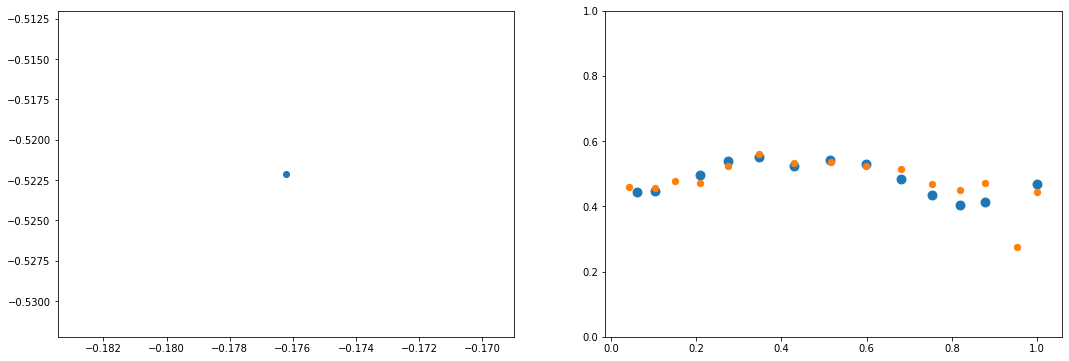

E0806 15:08:28.274299 140418116966208 web.py:1591] Uncaught exception GET /autoload.js?bokeh-autoload-element=32841&bokeh-absolute-url=http://172.17.0.2:32925&resources=none (172.17.0.1)
HTTPServerRequest(protocol='http', host='172.17.0.2:32925', method='GET', uri='/autoload.js?bokeh-autoload-element=32841&bokeh-absolute-url=http://172.17.0.2:32925&resources=none', version='HTTP/1.1', remote_ip='172.17.0.1', headers={'Host': '172.17.0.2:32925', 'Connection': 'keep-alive', 'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Safari/537.36', 'Accept': '*/*', 'Referer': 'http://172.17.0.2:8888/notebooks/STEP6%20beta%2C%20less%20clipping%20boundaries-Copy1.ipynb', 'Accept-Encoding': 'gzip, deflate', 'Accept-Language': 'en-US,en;q=0.9,it;q=0.8', 'Cookie': '_xsrf=2|62505fed|d0d2f21fdee70d27a1f05775a6d4d1da|1564560824; username-172-17-0-2-8888="2|1:0|10:1564560825|24:username-172-17-0-2-8888|44:NGYzMzAzZjM0ZmZlNGQwMmFmZDZiOGFjYjYxYjRmNTI=|

In [211]:
fig = plt.figure('test_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.)


for xy in qsh.ds_array.skip(qsh_pos).take(1):    
    xy,_ = xy
    x,y = tf.split(xy,2)
    ax2.scatter(x,y,s=80)
    m,v  = vae.encode([xy])
    gpt = m[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = vae.decode(m,apply_sigmoid=True)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())
    ax2.scatter(X,Y,s=40)

print(qsh_pos)    
qsh_pos += 1
    